<a href="https://colab.research.google.com/github/aysavs/COVID-19/blob/main/VGG_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Veri Kümesine erişmek için Google Drive'a bağlanma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID-19'

Mounted at /content/drive
/content/drive/My Drive/COVID-19


### Tüm kütüphane ve gereklilikleri içe aktarma

In [ ]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Bazı Parametrelerin Tanımlanması

In [ ]:
#görüntülerin yeniden boyutlandırma
IMAGE_SIZE = [224, 224] # veri kümesine bağlı olarak değişiklik yapılabilir

# eğitim yapılandırması:
epochs = 500
batch_size = 32

#yolları tanımla
covid_path = 'data/ct/CT_COVID'
noncovid_path = 'data/ct/CT_NonCOVID'

# Path.jpg veya jpeg türü görüntü almak için glob'u kullanma
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# Dosya değişkenlerinin içeriğini görselleştirme
print("İlk 5 Covıd Dosyası: ",covid_files[0:5])
print("Toplam Sayı:: ",len(covid_files))
print("İlk 5 NonCovıd Dosyası:  ",noncovid_files[0:5])
print("Toplam Sayı: ",len(noncovid_files))

First 5 Covid Files:  ['data/CT_COVID/ehaa254-p0-63%3.png', 'data/CT_COVID/2020.03.11.20033159-p12-45%1.png', 'data/CT_COVID/2020.03.12.20027185-p8-217.png', 'data/CT_COVID/2020.02.26.20026989-p34-114_2%1.png', 'data/CT_COVID/2020.02.27.20027557-p25-137%4.png']
Total Count:  349
First 5 NonCovid Files:  ['data/CT_NonCOVID/1310.png', 'data/CT_NonCOVID/709.png', 'data/CT_NonCOVID/781.png', 'data/CT_NonCOVID/921.png', 'data/CT_NonCOVID/782.png']
Total Count:  397


### Dosyalardan Resim ve Sınıf Etiketleri Getirme

In [ ]:
# Dosyalardan Resim ve Sınıf Etiketleri Getirme
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # dosya okuma
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # biçimi keras'a göre düzenleme
  image = cv2.resize(image,(224,224)) # modele göre yeniden boyutlandırma
  covid_images.append(image) # resim ekle
  covid_labels.append('CT_COVID') #sınıf etiketi ekle
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Veri kümesinden İlk 40 Görüntüyü Görselleştirme

In [ ]:
# rastgele bir resime bakma
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Pozitif COVID-19 CT Taramaları')
plot_images(noncovid_images, 'Negatif COVID-19 CT Taramaları')

NameError: ignored

### **Normalizasyon**
#### Model, görüntüleri piksel dizisi şeklinde alır. Bu nedenle pikselleri diziye dönüştürülür ve normalleştirilir

In [ ]:
#Diziye dönüştürme ve [0,1] aralığına normalleştirme
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Eğitim ve Test İçin Veri Setinin Bölünmesi**

In [ ]:
# Her iki görüntü türü için eğitim ve test setlerine ayırma
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Her iki görüntü türü için birleştirme kümeleri
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

#  Etiketleri kategorilere ayırma  model için 0 veya 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Eğitim ve Test setlerinden birkaç görüntüyü görselleştirme

In [ ]:
plot_images(covid_x_train, 'X_egitim')
plot_images(covid_x_test, 'X_test')
 # y_train ve _test, X_train ve X_test için COVID ve noncovıd'yi temsil eden 0 ve 1 sınıf etiketlerini içerir

### **Modeli Oluşturma Ve Görselleştirme**

In [ ]:
# Modeli Oluşturma
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# Modeli Görselleştirme
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


### Görüntü Büyütme
Görüntüleri eğitmek için farklı konumlarda, açılarda, vb. çevirmel

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


### Modeli Eğitmek

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
19/18 [==============================] - 13s 672ms/step - loss: 1.0572 - accuracy: 0.5587 - val_loss: 0.6449 - val_accuracy: 0.6400
Epoch 2/500
19/18 [==============================] - 9s 452ms/step - loss: 0.6540 - accuracy: 0.7030 - val_loss: 0.5838 - val_accuracy: 0.6867
Epoch 3/500
19/18 [==============================] - 8s 444ms/step - loss: 0.6082 - accuracy: 0.7013 - val_loss: 0.5421 - val_accuracy: 0.7333
Epoch 4/500
19/18 [==============================] - 9s 454ms/step - loss: 0.5547 - accuracy: 0.7466 - val_loss: 0.6580 - val_accuracy: 0.6933
Epoch 5/500
19/18 [==============================] - 9s 452ms/step - loss: 0.6709 - accuracy: 0.6862 - val_loss: 0.6873 - val_accuracy: 0.7133
Epoch 6/500
19/18 [==============================] - 8s 438ms/step - loss: 0.5554 - accuracy: 0.7416 - val_loss: 0.5402 - val_accuracy: 0.7533
Epoch 7/500
19/18 [==============================] - 8s 440ms/step - loss: 0.5281 - accuracy: 0.7483 - val_loss: 0.5204 - val_accuracy: 0.780

In [ ]:
# Modeli ve Ağırlıkları Kaydetme
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')

In [ ]:
# Kaydedilen modeli yükleme
model = load_model('vgg_ct.h5')

### **Tahminlerde Bulunma**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

### İlk 10 tahminin görselleştirilmesi

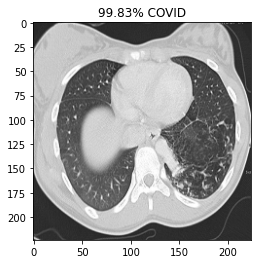

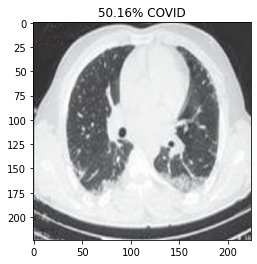

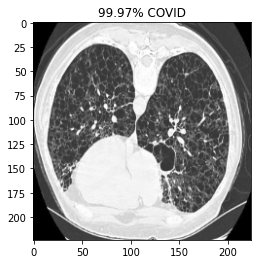

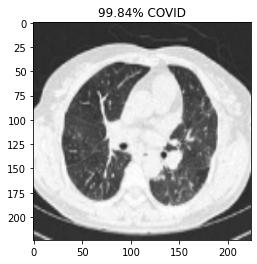

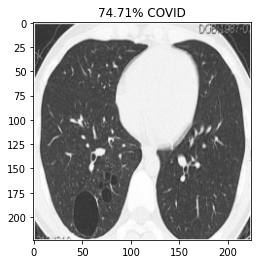

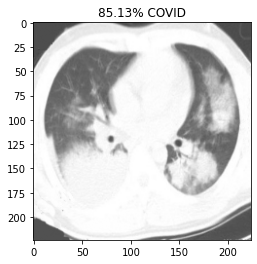

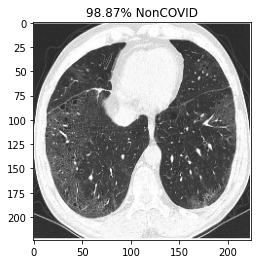

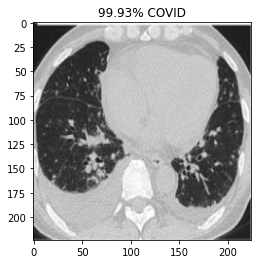

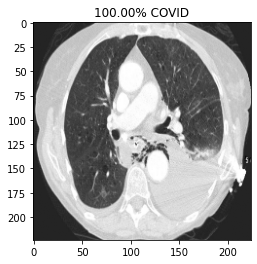

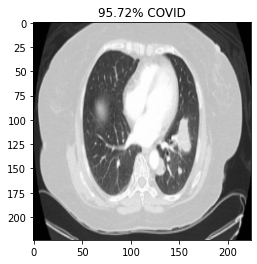

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
#  Binary dönüştürme
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

###  ROC Eğrisi Çizimi

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Eğrisi')
plt.xlabel('False Positive ')
plt.ylabel('True Positive ')
plt.grid(True)

###  Karışıklık Matrisi Grafiği

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Karışıklık Matrisi')
  plt.ylabel('Doruluk')
  plt.xlabel('Tahmin')
  plt.show()

print('Normalleştirme olmadan Karışıklık Matrisi')
plot_confusion_matrix(normalize=None)

print('Normalleştirilmiş Değerlerle Karışıklık Matrisi')
plot_confusion_matrix(normalize='true')

### Sınıflandırma Raporu

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        70
           1       0.94      0.94      0.94        80

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150




### **Doğruluk ve Kayıp Grafiği**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Dogruluk Modeli')
plt.ylabel('Dogruluk')
plt.xlabel('Epoch')

plt.legend(['Egitim', 'Test'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Kayıp Modeli')
plt.ylabel('Kayıp ')
plt.xlabel('Epoch')

plt.legend(['Egitim', 'Test'])
plt.savefig('vgg_ct_loss.png')
plt.show()